# Tutorial PXCT data analysis (Extra)- HERCULES school 2021

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) 
### email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

### <span style="color:red">** Disclaimer: This notebook is intended from educational reasons only.**</span>
<span style="color:red">**Warning: You should have completed parts 1 and 2 before starting part 3**</span>

#### Importing packages again
Since we start a new notebook, we need to import the packages again:

In [1]:
%matplotlib ipympl
# standard packages
import time
import warnings
warnings.filterwarnings('ignore')
# third party packages
import ipympl
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import toupy

#### Let us reload our data 
We do this the same way we did in Part 2, but we only change the filename to `PXCTalignedprojections.npz`:

In [2]:
fname = 'PXCTalignedprojections.npz'
data_dict = np.load(fname) # load the file
list(data_dict.files) # this one list the keys of the data dictionary extracted from the file
wavelen = data_dict['wavelen']
pixsize = data_dict['psize']
theta = data_dict['theta']
projections = data_dict['projections'] # <- ATTENTION: this one is memory consuming. 
nproj, nr, nc = projections.shape
delta_theta = np.diff(theta)

print(f"The total number of projections is {nproj}")
print(f"The angular sampling interval is {delta_theta[0]:.02f} degrees")
print(f"The projection pixel size of the projections is {pixsize/1e-9:.02f} nm")
print(f"The wavelenth of the incoming photons is {wavelen/1e-10:.02f} Angstroms")

The total number of projections is 450
The angular sampling interval is 3.20 degrees
The projection pixel size of the projections is 28.64 nm
The wavelenth of the incoming photons is 2.00 Angstroms


Let us take a look at one projection. I will select the first and last ones,i.e. at angles 0 and 180-$\Delta\theta$ degress:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

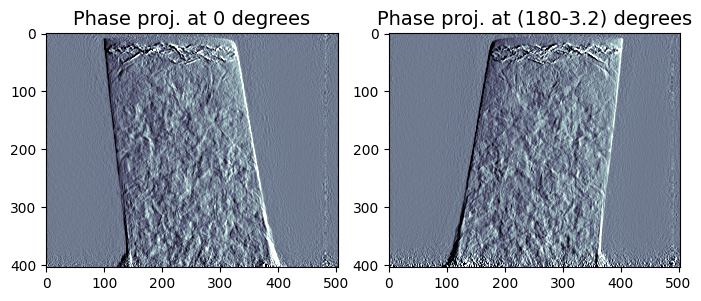

In [3]:
plt.close('all')
fig1 = plt.figure(1,figsize=(7,3))
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(projections[0],cmap='bone',vmin=-0.15,vmax=0.15)
ax1.set_title('Phase proj. at 0 degrees',fontsize = 14)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig1.colorbar(im1,cax=cax)
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(projections[-1],cmap='bone',vmin=-0.15,vmax=0.15)
ax2.set_title('Phase proj. at (180-3.2) degrees',fontsize = 14)
plt.tight_layout()
display.display(plt.gcf())
display.clear_output(wait=True)

## Advanced Mode: the spatial resolution estimate by Fourier Schell Correlation
In case you want to try to estimate the **spatial resolution** of the reconstructed slice, you can proceed to the next step. This part is memory and CPU-intensive and very time-consuming. 

<span style="color:red">**Proceed at your own responsibility**</span>

In [4]:
from toupy.resolution import FSCPlot, compute_2tomograms_splitted, split_dataset
from toupy.utils import sort_array, progbar
from toupy.tomo import tomo_recons

In [5]:
# initializing params
params = dict()

# =========================
# Edit session
# =========================
params["slicenum"] = 200  # Choose the slice
params["limsyFSC"] = [100, 300]  # number of slices for the 3D FSC
params["filtertype"] = "hann"  # Filter to use for FBP
params["freqcutoff"] = 1.0  # Frequency cutoff (between 0 and 1)
params["circle"] = True
params["algorithm"] = "FBP"  # FBP or SART
params["derivatives"] = True  # only for FBP
params["calc_derivatives"] = False  # Calculate derivatives if not done
params["opencl"] = False  # enable reconstruction with Silx and openCL
params["apod_width"] = 50  # apodization width in pixels
params["thick_ring"] = 4  # number of pixel to average each FRC ring
params["crop"] = None #[1465, 1865, 935, 1335]  # [top, bottom, left, right]
params["vmin_plot"] = None  # 0.5e-5
params["vmax_plot"] = None  # None
params["colormap"] = "bone"  # colormap to show images
# =========================

In [6]:
# sorting theta
print("Sorting theta and projections accordingly.")
projections, theta = sort_array(projections, theta)
ntheta = theta.shape[0]
# convinient change of variables
slice_num = params["slicenum"]
vmin_plot = params["vmin_plot"]
vmax_plot = params["vmax_plot"]
limsyFSC = params["limsyFSC"]
nslices = limsyFSC[-1] - limsyFSC[0]
nprojs, nr, nc = projections.shape

Sorting theta and projections accordingly.


In [7]:
# initializing variables
tomogram1 = np.empty((nslices, nc, nc))
tomogram2 = np.empty((nslices, nc, nc))
sinogramempty = np.empty_like(np.transpose(projections[:, 0, :]))
sino1nr, sino1nc = sinogramempty.shape
sino2nr, sino2nc = sino1nr, sino1nc
sinogram1 = np.empty((nslices, sino1nr, int(sino1nc/2)))
sinogram2 = np.empty((nslices, sino2nr, int(sino2nc/2)))

In [8]:
# splitting the sinograms
for idx, ii in enumerate(range(limsyFSC[0], limsyFSC[-1])):
    strbar = "Sinogram for slice: {}".format(ii)
    sinogram = np.transpose(projections[:, ii, :])
    sinogram1[idx], sinogram2[idx], theta1, theta2 = split_dataset(
        sinogram, theta
    )
    progbar(idx + 1, nslices, strbar)

 ###############################################------------------------- [ 65.50%] Sinogram for slice: 230

 ######################################################################## [100.00%] Sinogram for slice: 299

In [9]:
# calculating the 2 tomograms
for idx, ii in enumerate(range(limsyFSC[0], limsyFSC[-1])):
    strbar = "Slice {}".format(ii)
    # dividing the data into two datasets and computing tomograms
    tomogram1[idx], tomogram2[idx] = compute_2tomograms_splitted(
        sinogram1[idx], sinogram2[idx], theta1, theta2, ** params
    )
    progbar(idx + 1, nslices, strbar)

 ######################################################################## [100.00%] Slice 299

Estimating the resolution by 3D FSC...
calling the class FSCplot
You are running in a Jupyter Notebook enviroment
Calling the class FourierShellCorr
Using ring thickness of 4 pixels
Using half-bit threshold
Using SNRt = 0.2071
Input images have 3 dimensions
Performing the apodization
Apodization in 3D. This takes time and memory...
Calculating the transverse apodization
Done. Time elapsed: 3.40s


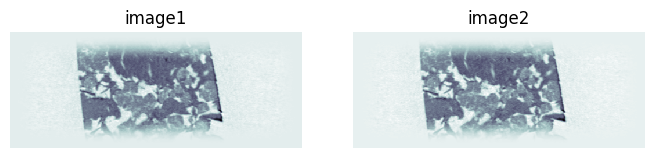

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calling method fouriercorr from the class FourierShellCorr
Done. Time elapsed: 141.40s


In [10]:
# 3D FSC
print("Estimating the resolution by 3D FSC...")
FSC3D = FSCPlot(
    tomogram1,
    tomogram2,
    "halfbit",
    params["thick_ring"],
    apod_width=params["apod_width"],
)

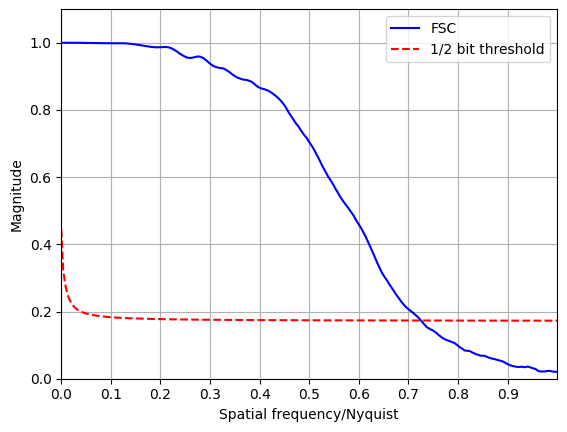

In [18]:
# Display the FSC curve
normfreqs, T, FSC3Dcurve = FSC3D.plot()
plt.grid()
plt.xticks(np.arange(0, 1.0, 0.1));
display.display(plt.gcf())

###### Let us zoom in into the intersection to see it better

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

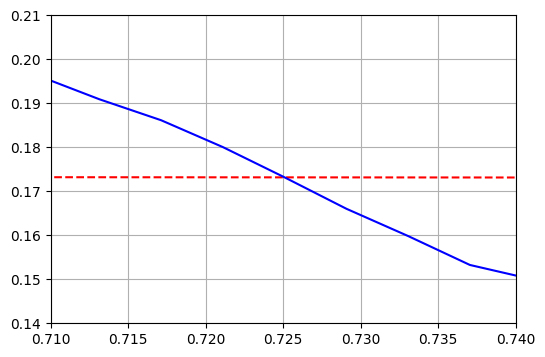

In [25]:
#zooming in into the FSC curve
plt.close('all')
plt.figure(figsize = (6,4))
plt.plot(normfreqs,T,'r--', label='1/2 bit threshold')
plt.plot(normfreqs,FSC3Dcurve,'b-', label='1/2 bit threshold')
plt.grid()
plt.xticks(np.arange(0, 1.0, 0.005));
plt.xlim([0.71,0.74])
plt.ylim([0.14,0.21])
display.display(plt.gcf())
display.clear_output(wait=True)

In [20]:
print("The voxelsize of the data is {:.02f} nm".format(pixsize * 1e9))
a = input("\nPlease, input the value of the intersection: ")
params["resolution3D"] = pixsize * 1e9 / float(a)
print("------------------------------------------")
print(
    "| Resolution is estimated to be {:.2f} nm |".format(params["resolution3D"])
)
print("------------------------------------------")

The voxelsize of the data is 28.64 nm

Please, input the value of the intersection: 0.725
------------------------------------------
| Resolution is estimated to be 39.50 nm |
------------------------------------------


## Congratulations! You finished the tutorial with success.